In [320]:
from collections import namedtuple
import jax_kalman as jk
import jax
import jax.numpy as jnp
import IWPprior

LikelihoodMarginalParams = namedtuple(
    "LikelihoodMarginalParams", ["A_rev", "b_rev", "Ch_rev", "m_out", "Ch_out"]
)
"""
Holds parameters for the likelihood and marginal distribution of the state.
Specifically, from P(X) and P(Y|X), we computed P(X|Y) and P(Y) where

P(X|Y) = N(`A_rev`*Y + `b_rev`, `Ch_rev`)
P(Y) = N(`m_out`, `Ch_out`)
"""


def chol_marginal_and_reverse(
    m_in, Ch_in, A_cond, b_cond, Ch_cond
) -> LikelihoodMarginalParams:
    """
    P(X) = N(m_in, Ch_in)
    P(Y|X) = N(A_cond @ X + b_cond, Ch_cond)

    Returns P(X|Y) = N(A_rev*Y + b_rev, Ch_rev)
    and P(Y) = N(m_out, Ch_out)
    """
    d_in = Ch_in.shape[0]
    d_out = Ch_cond.shape[0]

    zeros = jnp.zeros((d_out, d_in))
    qr_block = jnp.block(
        [
            [Ch_cond.T, zeros],
            [Ch_in.T @ A_cond.T, Ch_in.T],
        ]
    )
    R = jnp.linalg.qr(mode="r", a=qr_block)
    R_1 = R[:d_out, :d_out]
    R_2 = R[:d_out, -d_in:]
    R_3 = R[-d_in:, -d_in:]

    Ch_rev = R_3.T
    Ch_out = R_1.T
    m_out = A_cond @ m_in + b_cond

    A_rev = jnp.linalg.solve(R_1, R_2).T
    b_rev = m_in - A_rev @ m_out

    return LikelihoodMarginalParams(A_rev, b_rev, Ch_rev, m_out, Ch_out)


def chol_marginal_and_reverse_deterministic_conditional(
    m_in, Ch_in, A_cond, b_cond
) -> LikelihoodMarginalParams:
    R = jnp.linalg.qr((A_cond @ Ch_in.T).T, mode="r")
    Ch_out = R.T

    A_rev = jnp.linalg.solve(
        R, jnp.linalg.solve(R.T, (Ch_in @ Ch_in.T @ A_cond.T).T).T
    ).T
    # R_inv = jnp.linalg.inv(R)
    # A_rev = (Ch_in @ Ch_in.T @ A_cond.T) @ R_inv @ R_inv.T

    Ch_rev = Ch_in - A_rev @ A_cond @ Ch_in
    m_out = A_cond @ m_in + b_cond
    b_rev = m_in - A_rev @ m_out

    return LikelihoodMarginalParams(A_rev, b_rev, Ch_rev, m_out, Ch_out)

In [321]:
prior = jnp.array([[1.4]])
prior_cholvariance = jnp.array([[1.3]])
observation = jnp.array([[2.0]])
cond_cholvariance = jnp.array([[jnp.sqrt(0.0)]])

filtered_states = chol_marginal_and_reverse(
    prior, prior_cholvariance, observation, 1.0, cond_cholvariance
)

print(
    f"P(X|Y) = N({filtered_states.A_rev}@Y + {filtered_states.b_rev}, {filtered_states.Ch_rev @ filtered_states.Ch_rev.T} )"
)
print(
    f"P(Y) = N({filtered_states.m_out}, {filtered_states.Ch_out @ filtered_states.Ch_out.T})"
)

filtered_states = chol_marginal_and_reverse_deterministic_conditional(
    prior, prior_cholvariance, observation, 1.0
)

print(
    f"P(X|Y) = N({filtered_states.A_rev}@Y + {filtered_states.b_rev}, {filtered_states.Ch_rev @ filtered_states.Ch_rev.T} )"
)
print(
    f"P(Y) = N({filtered_states.m_out}, {filtered_states.Ch_out @ filtered_states.Ch_out.T})"
)

P(X|Y) = N([[0.5]]@Y + [[-0.5]], [[0.]] )
P(Y) = N([[3.8]], [[6.7599993]])
P(X|Y) = N([[0.49999994]]@Y + [[-0.49999976]], [[1.4210855e-14]] )
P(Y) = N([[3.8]], [[6.7599993]])


In [322]:
prior_mean = jnp.array([1.0, 1.0])
prior_cholvariance = jnp.array([[1.0, 0], [0.0, 1.0]])
A_cond_obs = jnp.array([[1.0, 0.0], [0.0, 1.0]])
Ch_cond_obs = jnp.array([[0.1, 0.0], [0.0, 0.1]])
b_cond_obs = jnp.array([0.0, 0.0])

filtered_states = chol_marginal_and_reverse(
    prior_mean,
    prior_cholvariance,
    A_cond_obs,
    b_cond_obs,
    Ch_cond_obs,
)

print(
    f"P(X|Y) = N(\n{filtered_states.A_rev}\n@Y + \n{filtered_states.b_rev}\n, \n{filtered_states.Ch_rev @ filtered_states.Ch_rev.T}\n )"
)
print(
    f"P(Y) = N(\n{filtered_states.m_out}\n, \n{filtered_states.Ch_out @ filtered_states.Ch_out.T}\n)"
)


P(X|Y) = N(
[[ 0.99009895 -0.        ]
 [-0.          0.99009895]]
@Y + 
[0.00990105 0.00990105]
, 
[[0.009901 0.      ]
 [0.       0.009901]]
 )
P(Y) = N(
[1. 1.]
, 
[[1.0100001 0.       ]
 [0.        1.0100001]]
)


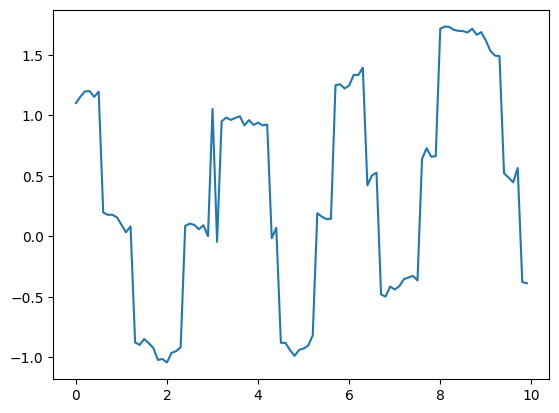

In [323]:
import matplotlib.pyplot as plt

time_step = 0.1
obs_noise = 0.1
n_steps = 100
length_scale = 0.9

collocation_points = jnp.arange(0, n_steps) * time_step


A, Q = IWPprior.get_IWP_Prior_SDE_coefficients(size=1, derivatives=1)
Q *= length_scale**2

A, Q = jk.fast_get_discrete_system_coeffs(A, Q, time_step)
b = jnp.zeros(A.shape[0])

A_cond_obs = jnp.array([[0.0, 1.0]])
Ch_cond_obs = jnp.array([[obs_noise]])
b_cond_obs = jnp.zeros(A.shape[0])

random_acc = (
    jnp.cumsum(
        jax.random.normal(
            jax.random.PRNGKey(0),
            (len(collocation_points),),
        ),
        axis=0,
    )
    * 0.2
)

# random_offset = jax.random.normal(jax.random.PRNGKey(0), (A.shape[0], 1))
observations = (jnp.round(jnp.cos(collocation_points * 2 + random_acc))).reshape(
    -1, 1
) + 0.2
observations += jnp.cumsum(
    jax.random.normal(jax.random.key(0), observations.shape) * 0.05, axis=0
)

prior_mean = jnp.array([0.0, 1.2])
prior_cholvariance = jnp.array([[0.001, 0.0], [0.0, 0.001]])
prior_cholvariance = jnp.linalg.cholesky(Q)

plt.plot(collocation_points, observations, label="observations");

In [324]:
def plot_state(states, ax):
    if isinstance(states, list):
        means = jnp.array([x.mean for x in states])
        stds = jnp.sqrt(
            jnp.array([jnp.diag((x.chol_cov @ x.chol_cov.T)) for x in states])
        )
    elif isinstance(states, tuple):
        means, chol_covs = states
        covariances = jnp.einsum("ijk,ilk->ijl", chol_covs, chol_covs)
        stds = jnp.sqrt(jnp.diagonal(covariances, axis1=1, axis2=2))

    ax.plot(collocation_points, means[:, 0], label="position")
    ax.fill_between(
        collocation_points,
        means[:, 0] - 3 * stds[:, 0],
        means[:, 0] + 3 * stds[:, 0],
        alpha=0.5,
    )
    ax.plot(collocation_points, means[:, 1], label="velocity")
    ax.fill_between(
        collocation_points,
        means[:, 1] - 3 * stds[:, 1],
        means[:, 1] + 3 * stds[:, 1],
        alpha=0.5,
    )
    ax.scatter(collocation_points, observations, label="velocity observations", s=4)
    ax.legend()


## filter and smooth, non-jit'able

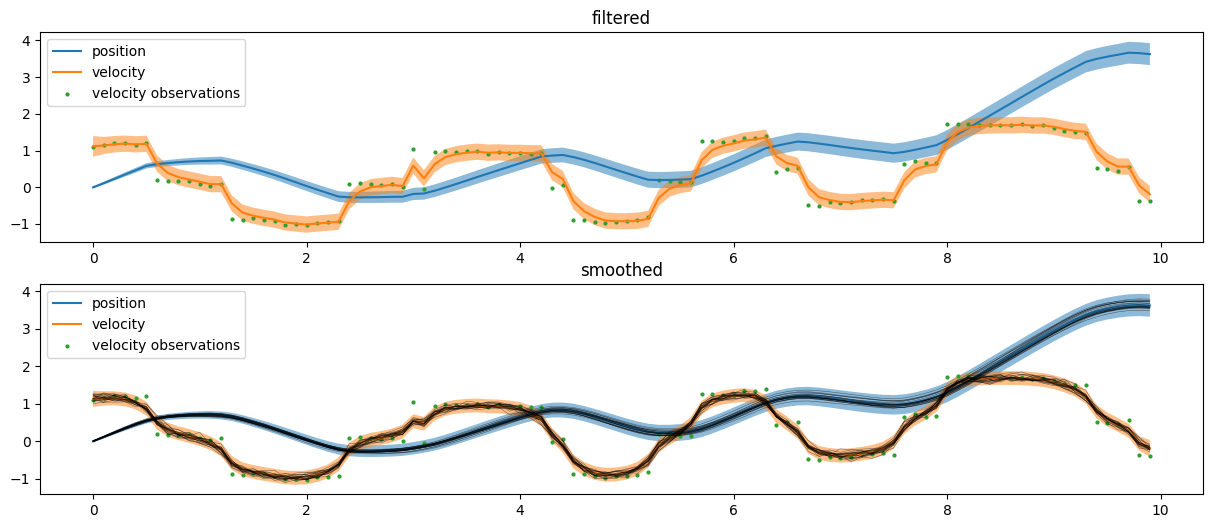

In [325]:
CholGauss = namedtuple("CholGauss", ["mean", "chol_cov"])


def get_posterior(
    prior_mean,
    prior_cholvariance,
    A_cond,
    b_cond,
    Ch_cond,
    observation,
) -> CholGauss:
    output = chol_marginal_and_reverse(
        prior_mean,
        prior_cholvariance,
        A_cond,
        b_cond,
        Ch_cond,
    )

    # form X | Y and compute its mean and covariance
    return CholGauss(output.A_rev @ observation + output.b_rev, output.Ch_rev)


ReverseParams = namedtuple(
    "reverse_params", ["A_rev_list", "b_rev_list", "Ch_rev_list"]
)


def batch_filter(
    prior_mean,
    prior_cholvariance,
    A_cond_obs,
    b_cond_obs,
    Ch_cond_obs,
    A_cond_state,
    b_cond_state,
    Ch_cond_state,
    observations,
) -> tuple[list[CholGauss], list[CholGauss], ReverseParams]:
    predicted_states = []
    filtered_states = []
    prior_state = CholGauss(prior_mean, prior_cholvariance)

    A_rev_states = []
    b_rev_states = []
    Ch_rev_states = []
    for observation in observations:
        filtered_state = get_posterior(
            prior_state.mean,
            prior_state.chol_cov,
            A_cond_obs,
            b_cond_obs,
            Ch_cond_obs,
            observation,
        )

        filtered_states.append(filtered_state)

        state_state_dist = chol_marginal_and_reverse(
            filtered_state.mean,
            filtered_state.chol_cov,
            A_cond_state,
            b_cond_state,
            Ch_cond_state,
        )

        A_rev_states.append(state_state_dist.A_rev)
        b_rev_states.append(state_state_dist.b_rev)
        Ch_rev_states.append(state_state_dist.Ch_rev)

        prior_state = CholGauss(
            mean=state_state_dist.m_out, chol_cov=state_state_dist.Ch_out
        )

        predicted_states.append(prior_state)

    return (
        filtered_states,
        predicted_states,
        filtered_states[-1],
        ReverseParams(
            A_rev_list=jnp.array(list(reversed(A_rev_states[:-1]))),
            b_rev_list=jnp.array(list(reversed(b_rev_states[:-1]))),
            Ch_rev_list=jnp.array(list(reversed(Ch_rev_states[:-1]))),
        ),
    )


def smooth(
    smooth_mean,
    smooth_chol_cov,
    A_rev_state,
    b_rev_state,
    Ch_rev_state,
):
    output = chol_marginal_and_reverse(
        smooth_mean,
        smooth_chol_cov,
        A_rev_state,
        b_rev_state,
        Ch_rev_state,
    )

    return CholGauss(output.m_out, output.Ch_out)


def batch_smooth(
    last_filtered_state: CholGauss,
    A_rev_states,
    b_rev_states,
    Ch_rev_states,
):
    n = len(b_rev_states)

    output_means = jnp.zeros((n, A_rev_states[0].shape[0]))
    output_means = output_means.at[-1].set(last_filtered_state.mean)

    output_chol_covs = jnp.zeros(
        (n, A_rev_states[0].shape[0], A_rev_states[0].shape[0])
    )
    output_chol_covs = output_chol_covs.at[-1].set(last_filtered_state.chol_cov)

    smooth_state = last_filtered_state
    for i in range(n):
        smooth_state = smooth(
            smooth_state.mean,
            smooth_state.chol_cov,
            A_rev_states[i],
            b_rev_states[i],
            Ch_rev_states[i],
        )

        output_means = output_means.at[-i - 1].set(smooth_state.mean)
        output_chol_covs = output_chol_covs.at[-i - 1].set(smooth_state.chol_cov)

    outputs = [
        CholGauss(mean, chol_cov)
        for mean, chol_cov in zip(output_means, output_chol_covs)
    ]
    outputs = outputs + [last_filtered_state]

    return outputs


def backwards_sample_trajectory(
    reverse_parameters: ReverseParams,
    final_state_dist: CholGauss,
    rng: jax.random.PRNGKey,
) -> tuple[jnp.ndarray, jax.random.PRNGKey]:
    Carry = namedtuple("Carry", ["last_position"])
    Input = namedtuple("Input", ["A_rev_list", "b_rev_list", "Ch_rev", "noise"])

    iid_normals = jax.random.normal(
        rng,
        shape=(
            reverse_parameters.A_rev_list.shape[0] + 1,
            final_state_dist.mean.shape[0],
        ),
    )

    def loop(carry: Carry, input):
        next_ = (
            input.A_rev_list @ carry.last_position
            + input.b_rev_list
            + input.Ch_rev @ input.noise
        )

        carry = Carry(last_position=next_)
        return carry, next_

    first_position = final_state_dist.mean + final_state_dist.chol_cov @ iid_normals[0]

    (carry, positions) = jax.lax.scan(
        loop,
        Carry(last_position=first_position),
        Input(
            reverse_parameters.A_rev_list,
            reverse_parameters.b_rev_list,
            reverse_parameters.Ch_rev_list,
            noise=iid_normals[1:],
        ),
    )
    positions = jnp.concatenate([first_position[None], positions], axis=0)

    positions = jnp.flip(positions, axis=0)

    return positions


filtered_states, _predicted_states, _final_filtered_state, reverse_parameters = (
    batch_filter(
        prior_mean=prior_mean,
        prior_cholvariance=prior_cholvariance,
        A_cond_obs=A_cond_obs,
        b_cond_obs=jnp.zeros(1),
        Ch_cond_obs=Ch_cond_obs,
        A_cond_state=A,
        b_cond_state=jnp.zeros(2),
        Ch_cond_state=Q,
        observations=observations,
    )
)

smoothed_states = batch_smooth(
    filtered_states[-1],
    reverse_parameters.A_rev_list,
    reverse_parameters.b_rev_list,
    reverse_parameters.Ch_rev_list,
)


trajectories = []
for i in range(20):
    rng = jax.random.PRNGKey(i + 1)
    trajectory = backwards_sample_trajectory(
        reverse_parameters, filtered_states[-1], rng
    )
    trajectories.append(trajectory)


fig, ax = plt.subplots(2, figsize=(15, 6))
ax[0].set_title("filtered")
ax[1].set_title("smoothed")
plot_state(filtered_states, ax[0])
plot_state(smoothed_states, ax[1])

for trajectory in trajectories:
    ax[1].plot(
        collocation_points,
        trajectory[:, 0],
        label="sample",
        color="k",
        linewidth=0.4,
        alpha=0.5,
    )
    ax[1].plot(
        collocation_points,
        trajectory[:, 1],
        label="sample",
        color="k",
        linewidth=0.4,
        alpha=0.5,
    )

## filter and smooth, jit'able - full JAX

In [326]:
from functools import partial


@jax.jit
def jax_batch_filter(
    prior_mean,
    prior_cholvariance,
    A_cond_obs,
    b_cond_obs,
    Ch_cond_obs,
    A_cond_state,
    b_cond_state,
    Ch_cond_state,
    observations,
) -> tuple[list[CholGauss], ReverseParams]:
    Carry = namedtuple("Carry", ["prior"])

    def loop(carry: Carry, observation):
        filtered_state = get_posterior(
            carry.prior.mean,
            carry.prior.chol_cov,
            A_cond_obs,
            b_cond_obs,
            Ch_cond_obs,
            observation,
        )

        state_state_dist = chol_marginal_and_reverse(
            filtered_state.mean,
            filtered_state.chol_cov,
            A_cond_state,
            b_cond_state,
            Ch_cond_state,
        )

        predicted_next_state = CholGauss(
            mean=state_state_dist.m_out, chol_cov=state_state_dist.Ch_out
        )

        carry = Carry(prior=predicted_next_state)
        state = (
            filtered_state,
            ReverseParams(
                A_rev_list=state_state_dist.A_rev,
                b_rev_list=state_state_dist.b_rev,
                Ch_rev_list=state_state_dist.Ch_rev,
            ),
        )
        return carry, state

    (_carry, (filtered_states, reverse_parameters)) = jax.lax.scan(
        loop, init=Carry(CholGauss(prior_mean, prior_cholvariance)), xs=observations
    )

    return (filtered_states, reverse_parameters)


@partial(jax.jit, static_argnames=("n_samples"))
def jax_batch_smooth_and_sample(
    last_filtered_state: CholGauss,
    reverse_parameters: ReverseParams,
    n_samples: int,
) -> tuple[list[CholGauss]]:
    Carry = namedtuple("Carry", ["next_state_smoothed", "last_sample"])

    noise = jax.random.normal(
        jax.random.PRNGKey(0),
        shape=(  # (T, n_samples, state_dim)
            reverse_parameters.A_rev_list.shape[0],
            n_samples,
            last_filtered_state.mean.shape[0],
        ),
    )

    jax.debug.print("noise shape {noise}", noise=noise.shape)

    def loop(carry: Carry, rev_params):
        rev_params, noise = rev_params
        smooth_state = smooth(
            carry.next_state_smoothed.mean,
            carry.next_state_smoothed.chol_cov,
            rev_params.A_rev_list,
            rev_params.b_rev_list,
            rev_params.Ch_rev_list,
        )

        t_sample = (
            jnp.einsum("ij, kj -> ki", rev_params.A_rev_list, carry.last_sample)
            + rev_params.b_rev_list
            + jnp.einsum("ij, kj -> ki", rev_params.Ch_rev_list, noise)
        )

        carry = Carry(next_state_smoothed=smooth_state, last_sample=t_sample)
        output = smooth_state.mean, smooth_state.chol_cov, t_sample

        return carry, output

    T_sample = last_filtered_state.mean + jnp.einsum(
        "ij, kj -> ki", last_filtered_state.chol_cov, noise[0]
    )
    # ^^^multiply each sample by the cholesky factor

    (_carry, (means, chol_covs, samples)) = jax.lax.scan(
        loop,
        init=Carry(next_state_smoothed=last_filtered_state, last_sample=T_sample),
        xs=(reverse_parameters, noise),
        reverse=True,
    )

    return means, chol_covs, samples

noise shape (Array(100, dtype=int32), Array(10, dtype=int32), Array(2, dtype=int32))


Text(0.5, 1.0, 'smoothed and sampled')

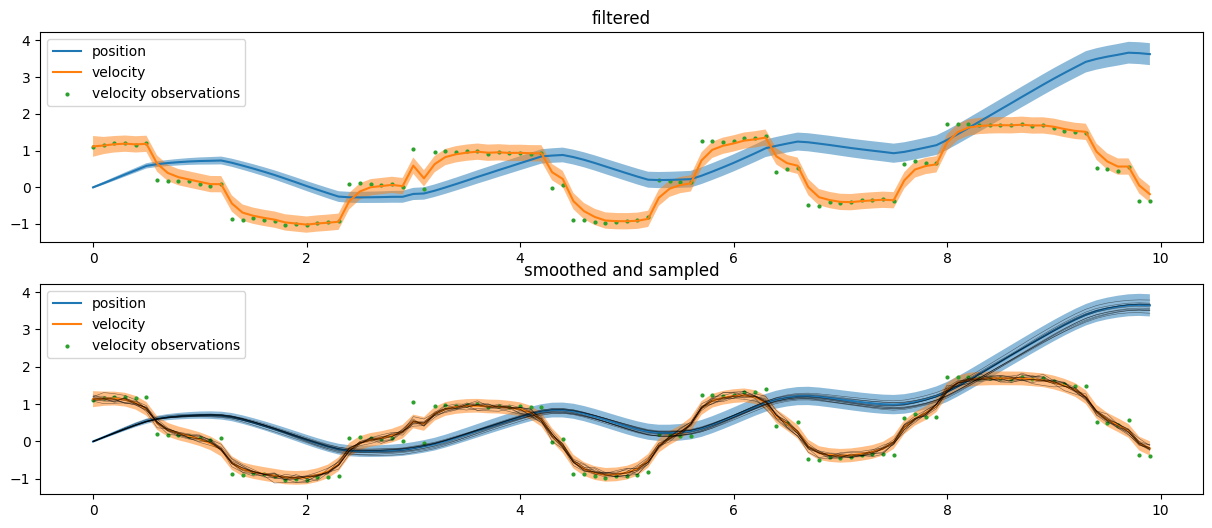

In [328]:
filtered, reverse_parameters = jax_batch_filter(
    prior_mean=prior_mean,
    prior_cholvariance=prior_cholvariance,
    A_cond_obs=A_cond_obs,
    b_cond_obs=jnp.zeros(1),
    Ch_cond_obs=Ch_cond_obs,
    A_cond_state=A,
    b_cond_state=jnp.zeros(2),
    Ch_cond_state=Q,
    observations=observations,
)
last_filtered = CholGauss(filtered.mean[-1], filtered.chol_cov[-1])
smooth_means, smooth_chol_covs, samples = jax_batch_smooth_and_sample(
    last_filtered,
    reverse_parameters,
    n_samples=10,
)

fig, ax = plt.subplots(2, figsize=(15, 6))
plot_state(filtered, ax[0])
plot_state(((smooth_means), (smooth_chol_covs)), ax[1])

for sample in samples.transpose(1, 0, 2):
    ax[1].plot(
        collocation_points,
        sample[:, 0],
        label="sample",
        color="k",
        linewidth=0.4,
        alpha=0.5,
    )
    ax[1].plot(
        collocation_points,
        sample[:, 1],
        label="sample",
        color="k",
        linewidth=0.4,
        alpha=0.5,
    )
ax[0].set_title("filtered")
ax[1].set_title("smoothed and sampled")